# Clustering

# Introduction 

The data being used in this analysis is a collection of country-wise economic, political, social, and human freedom measurements. 135 countries are included in this data from each of the seven continents. In this analysis, the intention is to elucidate underlying patterns in the data with regard to political regime. Each country is tagged with a particular political regime of these four descriptions: closed autocracy, electoral autocracy, electoral democracy, and liberal democracy. These governmental structures range from largely authoritarian to largely democratic. It is of interest to identify how factors that are essential to human freedom manifest in each of these political regimes. In the Western World, we assume that liberal democracy leads to maximal human freedom. This conception can be evaluated through clustering. The goal is to cluster the feature data in order to see if the indicators are highly variant between these regimes. Simply put, are the freedom indicators truly different between political regimes? The clustering analysis will aim to answer this query. 

# Theory

Three clustering methods will be implemented in this analysis - K-Means Clustering, Density-Based Spatial Clustering of Applications with Noise (DBSCAN), and Hierarchical Clustering. Each method operated differently. 

K-means clustering is a method to identify groupings, or clusters, of similar observations. The algorithm calculates the euclidean distance between some point, and all other points in the dataset. The point is assigned to the same group as the 'nearest' point - the point with the smallest euclidean distance. This process is conducted for each point in the dataset. 

"K" in "K-means" is the hyperparameter that represents the number of clusters to discern amongst the observations. The selection of K is important to the usefulness of the results, and thus is important. K is often selected with a a priori test. Two that are implemented in this analysis is the elbow method. The elbow method involves trying many values of K and finding the sum of squared variance within each cluster. These statistics are then plotted, and hte plot takes on somewhat of an L shape, with potential K values along the x axis and the sum of squares on the y axis. This L shape will begin high and break into a more constant variance. The break point, or the 'elbow' is identified visually and that is a reasoable selection for k that minimizes intercluster variance optimally. 

ensity-Based Spatial Clustering of Applications with Noise (DBSCAN) is another clustering method that is used in this analysis. DBSCAN uses density to determine cluster groupings of observations in a data set. DBSCAN identifies neighbors, or near points, to each point and calculates an optimal density. The density refers to the number of points that have to be within range to create a neighborhood, or a cluster.

K-means clustering reqiures the user setting a hyperparameter of K. DBSCAN does not require this setting, as it computes density mathematically within the algorithm. The silhouette score is used to evalaute the performance of the model. Silhouette score is a measure of how pure the cluster is that was identified by the algorithm. The score is on the range (-1 to1), where 0.5 is typically a good cluster, and values below indicate poor clustering. 

Hierarchical clustering is the third algorithm that is implemented in this analysis. Hierarchical clustering is an algorithm that builds a tree or bracket like data structure. This strucutre is build on observation similarity. This can be understool like an evolutionary tree in biology. This method creates many branches based on the distance between clusters. At any point a division, or a branch can be considered a cluster. In an evolutoinary tree, a cluster could be family, or genus for example.

Hierarchical clustering has two types: agglomerative and divisive. Agglomerative clustering starts with each observation and merges them upward to construct the tree. Divisive begins with one large cluster and divides observations downwards from there. Agglmomerative clustering will be used in this analysis.

# Methods

### Data Import

In [55]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

### Preprocessing

In [56]:
df = pd.read_csv('C:\\Users\\erinb\\OneDrive\\Documents\\Georgetown\\DSAN 5000\\dsan-5000-project-ebevec\\data\\01-modified-data\\data_clean2.csv')
df = df.replace(",", "", regex = True)
df.iloc[:,2:20] = df.iloc[:,2:20].apply(pd.to_numeric)

In [57]:
# Linear Interpolation
full_df = df.dropna()

# GDP
delta = full_df['GDP_2020'] - full_df['GDP_2019']
delta = delta.mean()

df['GDP_2020'] = df['GDP_2020'].fillna(df['GDP_2019'] + delta)
df['GDP_2019'] = df['GDP_2019'].fillna(df['GDP_2020'] - delta)
df.head()

# Population 
delta2 = full_df['pop_2020'] - full_df['pop_2019']
delta2 = delta2.mean()

df['pop_2020'] = df['pop_2020'].fillna(df['pop_2019'] + delta)
df['pop_2019'] = df['pop_2019'].fillna(df['pop_2020'] - delta)
df.head()

# Unemployment - Too many NaN for interpolation. Dropping columns. Imputation unreasonable for country-wise comparion.
df = df.drop(columns = ['unemployment_2019', 'unemployment_2020'])
df = df.iloc[:, 1:]
df.head()

,Country,GDP_2019,GDP_2020,pop_2019,pop_2020,hf_score_2019,hf_rank_2019,pf_religion_2019,pf_expression_2019,ef_score_2019,...,hf_score_2020,hf_rank_2020,pf_religion_2020,pf_expression_2020,ef_score_2020,pf_ss_2020,Year,Learning.Adjusted.Years.of.School,regime_2019,regime_2020
0,Albania,1652.440564,1644.08,2.881,2.878,8.07,42,9.737500,6.248600,7.79,...,7.67,47,9.757500,6.106867,7.64,9.249726,2020,8.953018,electoral autocracy,electoral autocracy
1,Algeria,18485.260564,18476.90,43.424,43.851,5.08,155,5.236667,4.586654,4.86,...,5.13,154,5.417292,4.395414,5.12,8.840074,2020,7.091553,electoral autocracy,electoral autocracy
2,Angola,33049.360564,33041.00,32.354,33.428,5.96,127,6.736667,5.500711,5.55,...,5.97,122,6.746042,5.597544,5.91,8.473782,2020,4.234978,electoral autocracy,electoral autocracy
3,Argentina,27489.800564,27481.44,44.939,45.388,7.33,75,9.859375,8.205444,5.44,...,6.99,74,9.873750,8.389844,4.87,8.504898,2020,8.411310,electoral democracy,electoral democracy
4,Armenia,6190.260564,6181.90,2.963,2.962,8.32,34,8.338542,7.617444,7.98,...,8.14,26,8.389792,7.580944,7.84,9.395818,2020,7.994621,electoral democracy,electoral democracy


In [58]:
x = df.iloc[:, 1:18]
x = StandardScaler().fit_transform(x)
y = df.iloc[:, 20]

### Function Definition

In [77]:
def plot(X,color_vector):
    fig, ax = plt.subplots()
    ax.scatter(X[:,0], X[:,1],c=color_vector, cmap="viridis") #, alpha=0.5) #, c=y
    ax.set(xlabel='Feature-1 (x_1)', ylabel='Feature-2 (x_2)',
    title='Cluster data')
    ax.grid()
    # fig.savefig("test.png")
    plt.show()

from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
def maximize_silhouette(X,algo="birch",nmax=20,i_plot=False):
    # PARAM
    i_print=False

    #FORCE CONTIGUOUS
    X=np.ascontiguousarray(X) 

    # LOOP OVER HYPER-PARAM
    params=[]; sil_scores=[]
    sil_max=-10
    for param in range(2,nmax+1):
        if(algo=="birch"):
            model = sklearn.cluster.Birch(n_clusters=param).fit(X)
            labels=model.predict(X)

        if(algo=="ag"):
            model = AgglomerativeClustering(n_clusters=param).fit(X)
            labels=model.labels_

        if(algo=="dbscan"):
            param=0.5*(param-1)
            model = DBSCAN(eps=param).fit(X)
            labels=model.labels_

        if(algo=="kmeans"):
            model = KMeans(n_clusters=param).fit(X)
            labels=model.predict(X)

        try:
            sil_scores.append(silhouette_score(X,labels))
            params.append(param)
        except:
            continue 

        if(i_print): print(param,sil_scores[-1])
        
        if(sil_scores[-1]>sil_max):
             opt_param=param
             sil_max=sil_scores[-1]
             opt_labels=labels

    print("OPTIMAL PARAMETER =",opt_param)

    if(i_plot):
        fig, ax = plt.subplots()
        ax.plot(params, sil_scores, "-o")  
        ax.set(xlabel='Hyper-parameter', ylabel='Silhouette')
        plt.show()

    return opt_labels

## K-means Clustering

C:\Users\erinb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\erinb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\erinb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set

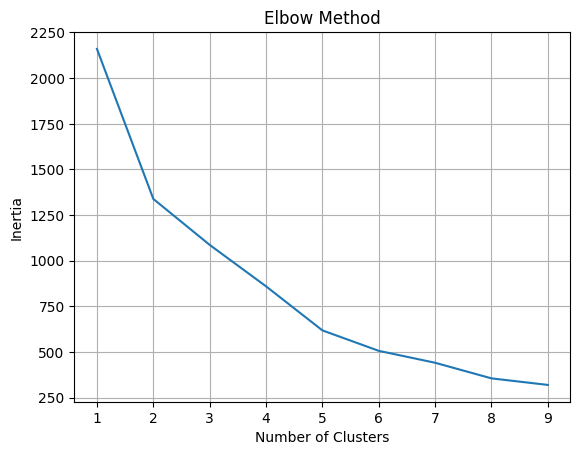

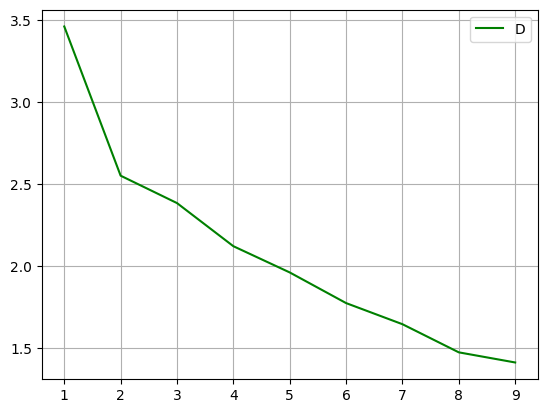

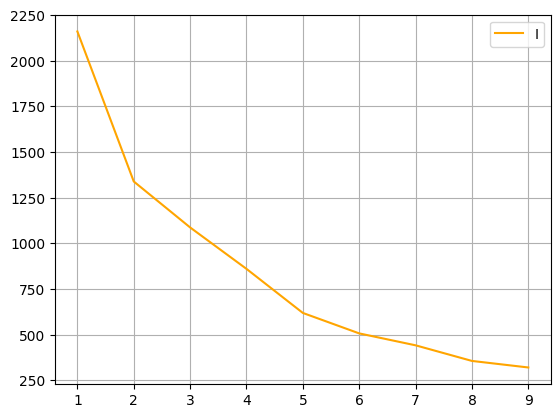

C:\Users\erinb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\erinb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\erinb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set

OPTIMAL PARAMETER = 4


C:\Users\erinb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\erinb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\erinb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set

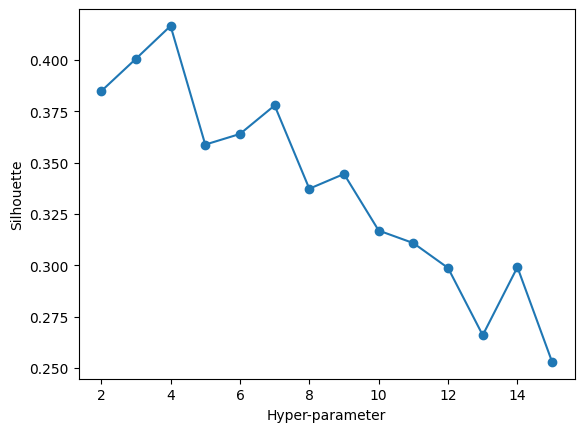

array([1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 2, 3, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       3, 0, 0])

In [78]:
# for k means clustering we will use the elbow method to find the optimal number of clusters. we will use the inertia_ attribute to find the sum of squared distances of samples to their closest cluster center. we will use the range of 1 to 10 clusters. plot the inertia_ values for each number of clusters. make sure to save it in a dataframe and plot it using matplotlib.
inertias = []
distortion = []
K = range(1, 10)
for k in K:
    model = KMeans(n_clusters=k).fit(x)
    model.fit(x)
    inertias.append(model.inertia_)
    
    distortion.append(sum(np.min(cdist(x, model.cluster_centers_, 'euclidean'), axis=1)) / x.shape[0])

plt.plot(K, inertias)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid()
plt.show()

# Distortion, Inertia
plt.plot(K, distortion, color = 'green')
plt.legend('Distortion')
plt.grid()
plt.show()

plt.plot(K, inertias, color = 'orange')
plt.legend('Inertia')
plt.grid()
plt.show()

# Silhouette method
maximize_silhouette(x,algo="kmeans",nmax=15, i_plot=True)

C:\Users\erinb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\erinb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


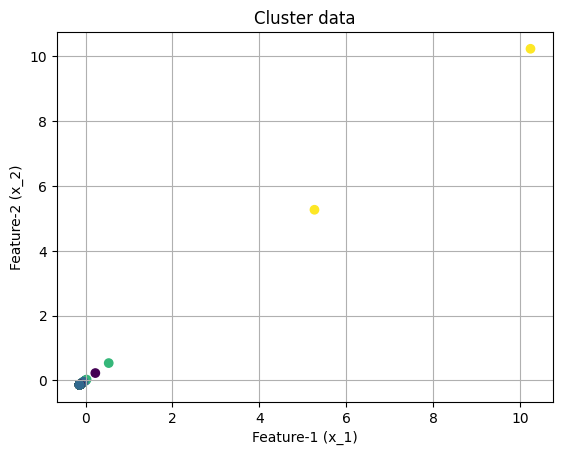

0.3386557538343144

In [87]:
from sklearn.metrics import silhouette_score
model2 = KMeans(n_clusters=4).fit(x)
model2.fit(x)

plot(x, color_vector=model2.labels_)

silhouette_score(x, model2.labels_)


## DBSCAN

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
DBSCAN(eps=3, min_samples=2)
OPTIMAL PARAMETER = 2.5


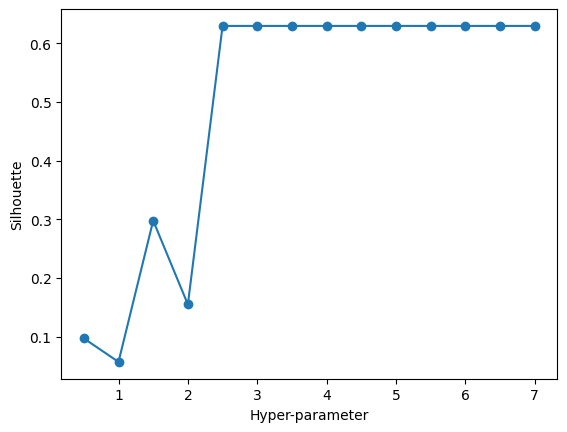

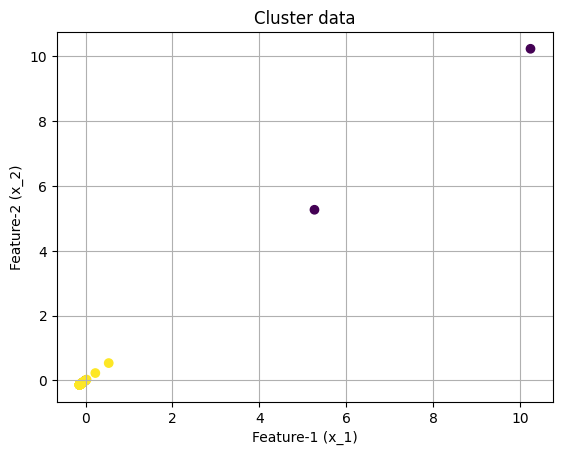

0.6299618630832903


In [93]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=3, min_samples=2).fit(x)
print(clustering.labels_)
print(clustering)

opt_labels=maximize_silhouette(x,algo="dbscan",nmax=15, i_plot=True)
plot(x,opt_labels)

print(silhouette_score(x, opt_labels))

## Hierarchical Clustering

OPTIMAL PARAMETER = 7


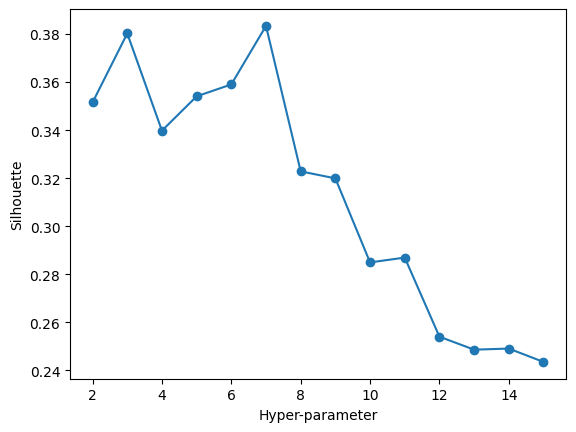

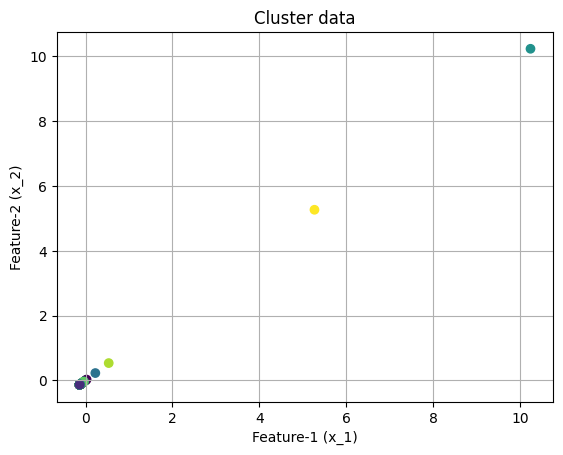

0.3833891675228451


In [89]:
# Perform Agglomerative Clustering
opt_labels=maximize_silhouette(x,algo="ag",nmax=15, i_plot=True)
labels=model.predict(x)
plot(x,labels)
print(silhouette_score(x, opt_labels))

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [85.0, 85.0, 95.0, 95.0],
  [105.0, 105.0, 115.0, 115.0],
  [145.0, 145.0, 155.0, 155.0],
  [185.0, 185.0, 195.0, 195.0],
  [175.0, 175.0, 190.0, 190.0],
  [165.0, 165.0, 182.5, 182.5],
  [150.0, 150.0, 173.75, 173.75],
  [135.0, 135.0, 161.875, 161.875],
  [125.0, 125.0, 148.4375, 148.4375],
  [110.0, 110.0, 136.71875, 136.71875],
  [215.0, 215.0, 225.0, 225.0],
  [275.0, 275.0, 285.0, 285.0],
  [265.0, 265.0, 280.0, 280.0],
  [355.0, 355.0, 365.0, 365.0],
  [345.0, 345.0, 360.0, 360.0],
  [335.0, 335.0, 352.5, 352.5],
  [325.0, 325.0, 343.75, 343.75],
  [315.0, 315.0, 334.375, 334.375],
  [385.0, 385.0, 395.0, 395.0],
  [405.0, 405.0, 415.0, 415.0],
  [445.0, 445.0, 455.0, 455.0],
  [435.0, 435.0, 450.0, 450.0],
  [425.0, 425.0, 442.5, 442.5],
  [410.0, 410.0, 433.75, 433.75],
  [565.0, 565.0, 575.0, 575.0],
  [585.0, 585.0, 595.0, 595.0],
  [615.0, 615.0, 625.0, 625.0],
  [665.0, 665.0, 675.0, 675.0],
  [655.0, 655.0, 670.0, 670.0],
  [685.0, 68

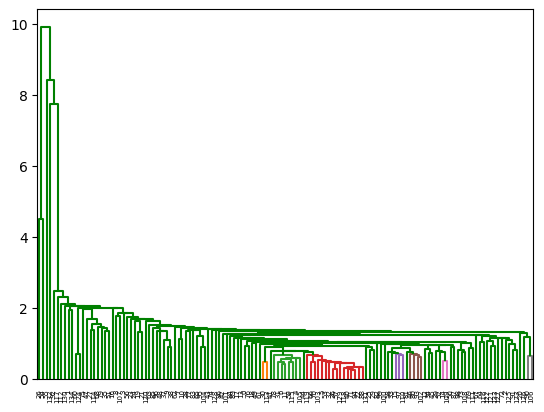

In [76]:
# create linkage for agglomerative clustering, and the dendrogram for the linkage. Suggest the optimal number of clusters based on the dendrogram.
from scipy.cluster import hierarchy
link = hierarchy.linkage(x, 'single')
hierarchy.dendrogram(link, above_threshold_color="green", color_threshold=.7)

# Results

The K-means clustering analysis revealed that the optimal cluster size is 4. The silhouette score of this analysis is 0.41, which is not optimal cluster separation. However, this is consistent with the four categories of political regime that are the true labels in this context, but it is unclear if the labeling is consistent. 

The DBSCAN analysis revelaed that two clusters are optimal. The analysis also had the highest respectvie silhouette score of 0.63, which is indicative of good cluster separation. 

The heirarchical clustering analysis indicated that 7 clusters are optimal. The silhouette score in this case was 0.38, the lowest performing of the clustering algorithms.

These three analyses are inconsistent. This is likely due to the differnet mechanisms by which clustering occurs. K-means relies on an a priori hyperparameter selection, which may bias the reuslts. The DBSCAN had the best cluster separation, but due to the fact that the clusters are implicitly ill defined with outlying points, this is unliekly to be the most informative option. The heirarchical clustering had the worst performance and the highest number of clusters. These results are too granular to be the most useful. The implicitly ill defined clusters and the outlying points may have caused the inconsistency between these clustering algorithms. 

The clusters revealed that some countries are outliers in terms of features.

# Conclusions

The clustering analysis demonstrated that the clusters are relatively ill defined regardless of the method. The best performing alogirthm was DBSCAN, which identified two clusters. One contained most of the observations, or countries, while the other contained fewer outlying points. This may indicate consistency between the feature manifestations within countries. Or, it may be biased by the outlying countries. These points need further investigation to determine if the clusters are meaningfully defined without the outlying points. 

# References

 The base code for this analysis was sources from the Georgetown University DSAN 5000 course lab 4.1 demonstration. 